In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('house_prices.csv')
df_new = df[df.BldgType=='1Fam'].copy()
df_new = df_new.dropna()
df_new.head()

,Id,BldgType,LotArea,GrLivArea,YearBuilt,YrSold,SalePrice
0,1,1Fam,8450,1710.0,2003,2008,208500
2,3,1Fam,11250,1786.0,2001,2008,223500
3,4,1Fam,9550,1717.0,1915,2006,140000
4,5,1Fam,14260,2198.0,2000,2008,250000
5,6,1Fam,14115,1362.0,1993,2009,143000


In [3]:
train_raw = df_new[df_new.YrSold < 2010].reset_index(drop=True)
test_raw = df_new[df_new.YrSold >= 2010].reset_index(drop=True)
train = train_raw[['LotArea','GrLivArea','YearBuilt','YrSold','SalePrice']].copy()
test = test_raw[['LotArea','GrLivArea','YearBuilt','YrSold','SalePrice']].copy()

In [4]:
features = list(train.columns)
target = "SalePrice"
features.remove(target)

X = train_raw[features].copy()
y = train_raw[target].copy()

X_test = test[features].copy()
y_test = test[target].copy()

# Validation Data

In [5]:
from sklearn.model_selection import train_test_split

**Example:** Split training data in to new training data and validation data.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size=0.2, 
                                                      random_state=2022)

In [7]:
X_train.head()

,LotArea,GrLivArea,YearBuilt,YrSold
268,9855,1689.0,1956,2009
16,14230,1600.0,2007,2009
141,12435,1792.0,2001,2008
854,16545,2450.0,1998,2009
245,14154,2172.0,2006,2007


**Example:** Find the best **alpha** for Lasso using **validation score**.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [9]:
avalues=list(np.logspace(-3, 3, 13))
mse = []
for a in avalues:
    steps = [('poly', PolynomialFeatures(degree=3)),
             ('rescale', MinMaxScaler()),
             ('lr', Ridge(alpha=a, max_iter=100000))]
    model = Pipeline(steps)
    model = model.fit(X_train, y_train)
    mse.append(mean_squared_error(y_valid, model.predict(X_valid)))

In [10]:
import matplotlib.pylab as plt
%matplotlib inline

Text(0.5, 1.0, 'Loss vs. alpha using Ridge')

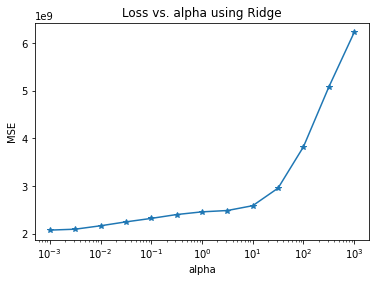

In [11]:
plt.plot(avalues, mse, marker='*')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Loss vs. alpha using Ridge')

<font color='red'>Question:</font> What are training, validation, and testing data for? Why did we use validation data to find the best **alpha**? Can we use test data to find the best **alpha**?

We use training data to train our model and first test it on validation data to see how it performs. If it doesnt perform well, we make some changes to model like tuning hyperparameters and test in on validation data again till it performs well. Testing data is used to see how well final model is performing on unseen data. We dont use testing set to tune hyperparameters.  

Testing on validation data is a part of training process since after testing on it we can make changes to model. We cant use testing data because it has to remain separate from training process so that we can see unbiased results.

# K-fold Cross Validation

<font color='red'>Assignment:</font> Use **KFold** instead of **train_test_split** to find the best **alpha**. 

In [12]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=2022)
kf.get_n_splits(X)

5

In [13]:
avalues=list(np.logspace(-3, 3, 13))
mse_kfold = {}
for a in avalues:
    mse_kfold[a] = 0

for train_index, valid_index in kf.split(X,y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    print('Train length', len(train_index), 'Train index:', train_index[0:5], 
          'Valid length', len(valid_index),'Valid index:',valid_index[0:5])
    mse = {}
    for a in avalues:
        steps = [('poly', PolynomialFeatures(degree=3)),
             ('rescale', MinMaxScaler()),
             ('lr', Ridge(alpha=a, max_iter=100000))]
        model = Pipeline(steps)
        model = model.fit(X_train, y_train)
        mse_vals = mean_squared_error(y_test, model.predict(X_test))
        mse[a] = mse_vals
        mse_kfold[a] = mse_kfold[a] + mse_vals

Train length 698 Train index: [0 1 2 3 4] Valid length 175 Valid index: [ 7 10 27 32 34]
Train length 698 Train index: [0 2 3 5 7] Valid length 175 Valid index: [ 1  4  6 13 15]
Train length 698 Train index: [0 1 3 4 5] Valid length 175 Valid index: [ 2  9 17 21 22]
Train length 699 Train index: [0 1 2 4 6] Valid length 174 Valid index: [ 3  5  8 20 30]
Train length 699 Train index: [1 2 3 4 5] Valid length 174 Valid index: [ 0 11 12 14 18]


In [14]:
avalues

[0.001,
 0.0031622776601683794,
 0.01,
 0.03162277660168379,
 0.1,
 0.31622776601683794,
 1.0,
 3.1622776601683795,
 10.0,
 31.622776601683793,
 100.0,
 316.22776601683796,
 1000.0]

In [15]:
lowest_mse = min(mse.values())
lowest_mse_alpha = [key for key in mse if mse[key]==lowest_mse]
print("Key with minimum MSE is : " + str(lowest_mse_alpha))

Key with minimum MSE is : [0.001]


<font color='red'>Question:</font> What is the difference between **KFold** and **train_test_split**? What is the advantages and disadvanteges of k-fold cross validation?

train_test_split splits data into training and testing dataset in the ratio we specify (80/20 , 70/30). The training set is used to train the model and then we test it on testing set.

KFold essentially splits data into K Folds and then uses cross validation to see how well model performed on each fold. For training it uses (k-1) folds and tests it on the remaining fold.
Advantages: 1) KFold uses all of the data 
2) Is better for small sized data sets 
Disadvantages: 1)Not efficient for large datasets. 
2)All estimates depends on how big/small K value is

# 3. GridSearchCV

<font color='red'>Assignment:</font> By now, we have only tuned the value of **alpha**. Actually, **degree** in **PolynomialFeatures** is also a hyper parameter. Can we find the best values for both of them? You can try to use **GridSearchCV**, and also **make_scorer**.

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
avalues=list(np.logspace(-3, 3, 13))
tuned_parameters = [{'lr__alpha':avalues,'poly__degree':range(1,10)}]
my_mse = make_scorer(mean_squared_error, greater_is_better=False)

model = Pipeline([('poly', PolynomialFeatures()),
             ('rescale', MinMaxScaler()),
             ('lr', Ridge(alpha=avalues, max_iter=100000))])


GS = GridSearchCV(model, tuned_parameters, scoring = my_mse, cv = 5)

GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('rescale', MinMaxScaler()),
                                       ('lr',
                                        Ridge(alpha=[0.001,
                                                     0.0031622776601683794,
                                                     0.01, 0.03162277660168379,
                                                     0.1, 0.31622776601683794,
                                                     1.0, 3.1622776601683795,
                                                     10.0, 31.622776601683793,
                                                     100.0, 316.22776601683796,
                                                     1000.0],
                                              max_iter=100000))]),
             param_grid=[{'lr__alpha': [0.001, 0.0031622776601683794, 0.01,
                                        0.03162277660168379

In [20]:
#best Parameters for the alpha and polynomial degree
print(GS.best_params_)

#best mean squared error
print(GS.best_score_)

{'lr__alpha': 0.1, 'poly__degree': 3}
-2366806177.7285175
